# Chains and PT-TEBD

An introduction on how to use the OQuPy package to compute the dynamics of a chain of open quantum systems using the process tensor approach to time evolving block decimation (PT-TEBD). We illustrate this by applying PT-TEBD to a 5-site XYZ Heisenberg spin chain. This method and example is explained in detail in [Fux2022] ([arXiv:2201.05529](https://arxiv.org/abs/2201.05529)).

- [launch binder](https://mybinder.org/v2/gh/tempoCollaboration/OQuPy/HEAD?labpath=tutorials%2Fpt_tebd.ipynb) (runs in browser),
- [download the jupyter file](https://raw.githubusercontent.com/tempoCollaboration/OQuPy/main/tutorials/pt_tebd.ipynb), or
- read through the text below and code along.


**Contents:**

* Example - Heisenberg spin chain
    * 1. Closed Heisenberg spin chain
    * 2. Open Heisenberg spin chain

First, let's import OQuPy and some other packages we are going to use

In [1]:
import sys
sys.path.insert(0,'..')

import oqupy
import numpy as np
import matplotlib.pyplot as plt

and check what version of tempo we are using.

In [2]:
oqupy.__version__

'0.4.0'

Let's also import some shorthands for the spin-1/2 operators and and density matrices.

In [3]:
sx = 0.5 * oqupy.operators.sigma("x")
sy = 0.5 * oqupy.operators.sigma("y")
sz = 0.5 * oqupy.operators.sigma("z")
up_dm = oqupy.operators.spin_dm("z+")
down_dm = oqupy.operators.spin_dm("z-")
mixed_dm = oqupy.operators.spin_dm("mixed")

------------------------------------
## Example - Heisenberg spin chain

### 1. Closed Heisenberg spin chain

Let's calculate the dynamics of a short XYZ Heisenberg spin chain with the same parameters as in [Fux2022]. Before we include any environment coupling we first consider the closed chain with the Hamiltonian

$$ H_\mathrm{chain} = \sum_{n=1}^N \epsilon s_n^z
    + \sum_{n=1}^{N-1} \sum_{\gamma \in \{x,y,z\}}
        J^\gamma s_{n}^\gamma s_{n+1}^\gamma \,\mathrm{,}$$

with $N=5$, $\epsilon=1.0$, $J^x = 1.3$, $J^y = 0.7$, and $J^z = 1.2$.

In [4]:
N = 5
epsilon = 1.0
J = [1.3, 0.7, 1.2]

system_chain = oqupy.SystemChain(hilbert_space_dimensions=[2]*N)

for n in range(N):
    system_chain.add_site_hamiltonian(
        site=n,
        hamiltonian=epsilon*sz)

for n in range(N-1):
    for J_gamma, s_gamma in zip(J, [sx, sy, sz]):
        system_chain.add_nn_hamiltonian(
            site=n,
            hamiltonian_l=J_gamma*s_gamma,
            hamiltonian_r=s_gamma)

We begin with an initial chain state where the first spin is 'up' (in the $z$-basis) and all the others are 'down'.
$$\tilde{\rho}^A_\mathrm{chain} = | \uparrow \rangle \langle \uparrow |
    \otimes | \downarrow \rangle \langle \downarrow |
    \otimes | \downarrow \rangle \langle \downarrow |
    \otimes | \downarrow \rangle \langle \downarrow |
    \otimes | \downarrow \rangle \langle \downarrow | $$

In [5]:
initial_augmented_mps_A = oqupy.AugmentedMPS([up_dm, down_dm, down_dm, down_dm, down_dm])

To run a PT-TEBD simulation we need to choose three computation parameters:

1. The time step length `dt`,
2. The Trotterization order `order` (currently only `1` and `2` are implemented), and
3. The relative singular value truncation tolerance `epsrel`.

We describe details of the computation parameters in the supplemental material of [Fux2022].

In [6]:
pt_tebd_params = oqupy.PtTebdParameters(
    dt=0.2,
    order=2,
    epsrel=1.0e-6)

Next, we insert all this information into a new `PtTebd` object to prepare the simulation. We also specify a list of process tensors that represent the environment of each site of the chain. Because in this first example we don't have any environment, we specify all to be `None`. The `dynamics_sites` parameter allows us to specify a list of sites whose reduced density matrix shall be recorded during the propagation.

In [7]:
pt_tebd_closed = oqupy.PtTebd(
    initial_augmented_mps=initial_augmented_mps_A,
    system_chain=system_chain,
    process_tensors=[None, None, None, None, None],
    parameters=pt_tebd_params,
    dynamics_sites=[0, 1, 2, 3, 4])

We can then go ahead and set off the actual computation. Let's (for the sake of computation time) be modest and say we are only interested in 20 time steps.

In [8]:
num_steps = 20
print("PT-TEBD computation (closed spin chain):")
results_closed = pt_tebd_closed.compute(num_steps, progress_type="bar")

PT-TEBD computation (closed spin chain):
--> PT-TEBD computation:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.6s


The computation returns a results dictionary which in addition to the the dynamics of the before specified sites carries all sorts of other information about the propagation (such as the total spin chain norm, the bond dimensions of the augmented MPS, etc.)

In [9]:
print(f"Keys of the results dictionary: {results_closed.keys()}")
print(f"Keys of the dynamics results: {results_closed['dynamics'].keys()}")

Keys of the results dictionary: dict_keys(['time', 'norm', 'bond_dimensions', 'dynamics', 'pt_bond_dimensions'])
Keys of the dynamics results: dict_keys([0, 1, 2, 3, 4])


We can use the dynamics results to then compute the evolution of the $s^z_n$ observables.

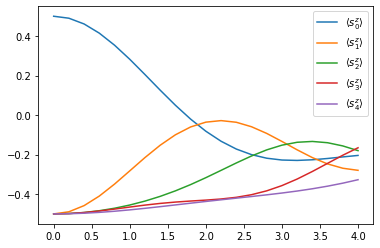

In [10]:
for site, dynamics in results_closed['dynamics'].items():
    plt.plot(
        *dynamics.expectations(sz, real=True),
        color=f"C{site}", linestyle="solid",
        label=f"$\\langle s_{site}^z \\rangle$")
plt.legend()

Yay! We can observe how the excitation travels along the chain.

### 2. Open Heisenberg spin chain

Now, let's add a strongly coupled and structured environment to the chain. We will couple a ohmic bosonic environment to the first spin through the environment Hamiltonian
$$ H^E = \sum_{k}^{\infty} s_1^y \left( g_k b_k^{\dagger} + h.c \right) + \omega_k b_k^{\dagger} b_k \,\mathrm{,}$$
where $b_k^{(\dagger)}$ are the bosonic lowering (raising) operators, and $s_1^y$ is the $y$ spin operator of the first site.
The coupling constants $g_k$ and frequencies $\omega_k$ are determined by the spectral density
$$ J(\omega) = \sum_{k}^{\infty} |g_k|^2 \delta(\omega - \omega_k) = 2 \alpha \, \omega \, e^{-\frac{\omega}{\omega_c}} \,\mathrm{.}$$

We choose the values $\alpha=0.32$ and $\omega_c=4.0$, and specify that the bosonic environment is initially at temperature $T=1.6$.

In [11]:
alpha = 0.32
omega_cutoff = 4.0
temperature = 1.6

correlations = oqupy.PowerLawSD(
    alpha=alpha,
    zeta=1,
    cutoff=omega_cutoff,
    cutoff_type='exponential',
    temperature=temperature)
bath = oqupy.Bath(sy, correlations)

For the process tensor approach to TEBD, we first need to compute the process tensors of the environments we wish to add to the TEBD evolution. For this we choose suitable parameters and carry out the computation (see Tutorial 02 - Time dependence and PT-TEMPO).

In [12]:
tempo_parameters = oqupy.TempoParameters(
    dt=pt_tebd_params.dt,
    dkmax=40,
    epsrel=1.0e-5)

In [13]:
print("Process tensor (PT) computation:")
pt = oqupy.pt_tempo_compute(
    bath=bath,
    start_time=0.0,
    end_time=num_steps * pt_tebd_params.dt,
    parameters=tempo_parameters,
    progress_type='bar')

Process tensor (PT) computation:
--> PT-TEMPO computation:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.2s


To see the effect of the environment clearly we start in a fully mixed chain state.

In [14]:
initial_augmented_mps_B = oqupy.AugmentedMPS([mixed_dm, mixed_dm, mixed_dm, mixed_dm, mixed_dm])

Again, we prepare a `PtTebd` object to collect all necessary information. We can reuse the before created `SystemChain` and `PtTebdParameters` objects. This time we set the first item in the list of process tensors to the process tensor we just computed. This attaches the above specified environment to the first chain site. Because we don't want to couple the other sites to any environment we keep them free by setting them to `None`.

In [15]:
pt_tebd_open = oqupy.PtTebd(
    initial_augmented_mps=initial_augmented_mps_B,
    system_chain=system_chain,
    process_tensors=[pt, None, None, None, None],
    parameters=pt_tebd_params,
    dynamics_sites=[0, 1, 2, 3, 4],
    chain_control=None)

In [16]:
print("PT-TEBD computation (open spin chain):")
results_open = pt_tebd_open.compute(num_steps, progress_type="bar")

PT-TEBD computation (open spin chain):
--> PT-TEBD computation:
100.0%   20 of   20 [########################################] 00:00:01
Elapsed time: 1.5s


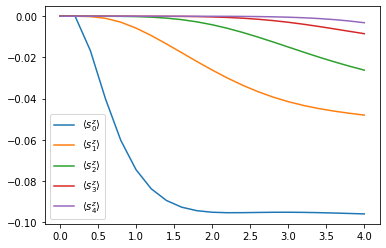

In [17]:
for site, dyn in results_open['dynamics'].items():
    plt.plot(*dyn.expectations(sz, real=True),
             color=f"C{site}", linestyle="solid",
             label=f"$\\langle s_{site}^z \\rangle$")
plt.legend()

We can see that the environment starts to hybridize with the first spin and then the other spins start being affected too.